In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import matplotlib.gridspec as gridspec

from tqdm import tqdm, trange

import time
import os, sys
import torch 

from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import default_cosmology
import lenstronomy.Util.constants as const
from lenstronomy.Data.psf import PSF
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
from lenstronomy.SimulationAPI.sim_api import SimAPI
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as util
from lenstronomy.LightModel.Profiles.interpolation import Interpol
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from astropy.cosmology import default_cosmology

from scipy import interpolate
from scipy import stats
from scipy.stats import chi2, rv_histogram

from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import LeaveOneOut, GridSearchCV

sys.path.append("../src/")
from resnet import ResNetRatioEstimator
from inference_utils import * 

# plot formatting 
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

rcnew = {"mathtext.fontset" : "cm", 
         "xtick.labelsize" : 18,
         "ytick.labelsize" : 18,
         "axes.titlesize" : 26, 
         "axes.labelsize" : 22,
         "xtick.major.size" : 8,      # major tick size in points
         "xtick.minor.size" : 4,      # minor tick size in points
         "ytick.major.size" : 8,      # major tick size in points
         "ytick.minor.size" : 4,      # minor tick size in points
         "legend.fontsize" : 22
        }
plt.rcParams.update(rcnew)

%config InlineBackend.figure_format = 'retina'

# from seaborn colorblind palette 
colors = ["#0173B2", "#CC78BC", "#029E73", "#D55E00", "#56B4E9", "#FBAFE4", "#DE8F05", "#CA9161", "#949494", "#ECE133"]

In [2]:
from platform import python_version

print(python_version())
print(torch.version.cuda)

3.9.12
11.6


In [3]:
def get_predictions(test_data, theta, model, device=torch.device('cuda:0')):
    '''
    Args: 
        test_data (np.array, torch.Tensor): input data into model 
        theta (np.array, torch.Tensor): parameter of interest 
        model (ResNetRatioEstimator): inference model 
        device (optional, torch.device): default torch.device('cuda:0'); gpu device for sending x
        
    Returns: 
        model outputs (np.array) for the given test_data input 
    '''
    with torch.no_grad():
        test_data = to_tensor(test_data)
        theta = to_tensor(theta)
        
        theta = theta.unsqueeze(1)
            
        predictions, logrs = model(test_data, x_aux=theta)
    
    return predictions.cpu().detach().numpy(), logrs.cpu().detach().numpy()



def find_closestvalue_indices(x, value, i_max): 
    '''
    Finds the indices of elements in x that are closest 
    to value on the two sides of x[i_max]; if i_max = 0, len(x)-1, 
    then i_low, i_high = i_max respectively 
    
    Args: 
        x (np.array): has shape (len(x),); array of values 
        value (float)
        i_max (int): index dividing x array into two segments
        
    Returns: 
        i_low, i_high: x[i_low] and x[high] are the nearest to value
                    in x with i_low =< i_max and i_high >= i_max 
    '''
    x_left, x_right = x[:i_max], x[i_max + 1:]
    
    if (len(x_left) == 0): i_low = i_max 
    else: i_low = np.argmin(np.abs(x_left - value))
    
    if (len(x_right) == 0): i_high = i_max 
    else: i_high = np.argmin(np.abs(x_right - value)) + i_max + 1
    
    return i_low, i_high 



def get_errors(logrs, targets_test, inds_max, option='both', threshold=stats.chi2.isf(0.32, df=1)): 
    '''
    Args: 
        logrs (ndarray): log llr matrix (shape: (len(targets_test), number of samples = len(inds_max))) 
        targets_test (array): a list of values being tested for llr 
        inds_max (array): indices at which the llr is max for all samples 
        option (str): default "both"; options are "low", "high" and "both"
        threshold (float): default chi2.isf(0.32, df=1); threshold in TS for determining the errors 
    
    Return: 
        errlow (np.array): lowerbound errors on llr (if option="low" or "both") otherwise empty 
        errhigh (np.array): upperbound errors on llr (if option="high" or "both") otherwise empty
    '''
    
    assert option == 'both' or option == 'low' or option == 'high'
    
    targets_errlow = [] 
    targets_errhigh = [] 

    if (option == 'both'): 
        for i, ind_max in enumerate(inds_max): 
            i_low, i_high = find_closestvalue_indices(-2*logrs[:, i], threshold, ind_max)
            
            targets_errlow.append(targets_test[i_low])
            targets_errhigh.append(targets_test[i_high])
    elif (option == 'low'): 
        for i, ind_max in enumerate(inds_max): 
            if (len(logrs[:ind_max, i]) == 0): i_low = ind_max 
            else: i_low = np.argmin(np.abs(logrs[:ind_max, i] + threshold/2))
            targets_errlow.append(targets_test[i_low])
    else: 
        for i, ind_max in enumerate(inds_max): 
            if (len(logrs[ind_max+1:, i]) == 0): i_high = 0 
            else: i_high = np.argmin(np.abs(logrs[ind_max+1:, i] + threshold/2))
            targets_errhigh.append(targets_test[ind_max+1+i_high])

    return np.array(targets_errlow), np.array(targets_errhigh)


    
def get_maxlogrs(logrs): 
    '''
    Args: 
        logrs (ndarray): matrix of logrs, each column corresponding to one logr distribution of a sample 
        
    Returns: 
        inds_max (np.array): indices in each column of logrs that give the max logr in the column 
        logrs_max (np.array): max logrs in each column 
    '''
    
    # get the values that give the highest likelihood for each sample 
    inds_max = np.argmax(logrs, axis=0).T
    logrs_max = np.amax(logrs, axis=0).T
    
    return inds_max, logrs_max 


def plot_predictions(model, thetas_test, thetas_exp, thetas_mean, data_test, color, error=None, label='', select=False, 
                     threshold=stats.chi2.isf(0.32, df=1), calib=False, **kwargs):
    '''
    Args:
        model (ResNetRatioEstimator): inference model 
        thetas_test (np.array): array of thetas to be tested on each image 
        thetas_exp (list-like): expected thetas corresponding to sample in data_test; len(thetas_exp) = len(data_test)
        thetas_mean (float): mean of training set thetas; to be subtracted from thetas_test before being fed into model
        data_test (np.array): array of input data (post whitening and masking) 
        color (str): color of scatter plot 
        error (str): default None; options are 'both', 'low', 'high'
        label (str): default empty string; label for scatter plot
        select (bool): default False; whether to select only the inputs with predictions far from the lower edge 
        threshold (float): default chi2.isf(0.32, df=1); threshold in TS for determining the errors  
        calib (bool): default False; whether to calibrate the logrs 
        
        optional args: (required if calib=True) 
            logrs_ref (np.array): reference distribution p_ref(r|theta) used for calibration, each row 
                corresponds to a theta value; len(thetas_test)=len(logrs_ref) 
            logrs_calib (np.array): calibration distribution p(r|theta) used for calibration, each row 
                corresponds to a theta value; len(thetas_test)=len(logrs_ref) 
            n_convolve (int): window size for moving average to smooth out the calibrated logrs 
        
    Returns: 
        predicted thetas corresponding to data_test, theta low errors (if option='low' or 'both') otherwise [], 
        theta high errors (if option='high' or 'both') otherwise [] 
        
    Side effect: 
        show the scatter plot 
    '''
    
    if calib: 
        logrs_ref = kwargs.get('logrs_ref')
        logrs_calib = kwargs.get('logrs_calib')
        n_con = kwargs.get('n_convolve') 
        
        assert logrs_ref is not None, 'Please provide an array of logrs for the reference distribution' 
        assert logrs_calib is not None, 'Please provide an array of logrs for the calibration distributions' 
        assert n_con is not None, 'Please provide a window length for moving average' 
        assert n_con % 2 == 1, 'Please provide an odd moving average window' 

    start_time = time.time()
 
    logrs = get_logrs(thetas_test - thetas_mean, data_test, model)       
    if calib: 
        logrs = calibrate(logrs, logrs_calib, logrs_ref) 
        if (n_con > 1): 
            thetas_test, logrs = convolve_logr(thetas_test, logrs, n_con)
        
    maxinds, maxlogrs = get_maxlogrs(logrs)
    
    if (select): 
        condition = maxinds > 20
        logrs = logrs.T[condition].T 
        maxlogrs = maxlogrs[condition]
        thetas_exp = thetas_exp[condition]
        maxinds = maxinds[condition]
    
    assert np.max(logrs.T[0]) == 0 

    thetas_pred = thetas_test[maxinds]   # get predicted values 

    print("--- %s seconds ---" % (time.time() - start_time))
    
    if error: 
        thetas_errlow, thetas_errhigh = get_errors(logrs, thetas_test, maxinds, option=error, threshold=threshold)

    plt.scatter(thetas_exp, thetas_pred, s=8, color=color, label=label, alpha=0.5)
    
    if error: 
        if (error == 'both'): 
            plt.errorbar(thetas_exp, thetas_pred, [thetas_pred-thetas_errlow, thetas_errhigh-thetas_pred], fmt='none', color=color, alpha=0.5, capsize=3, label='68% CI')
        elif (error == 'low'): 
            plt.errorbar(thetas_exp, thetas_pred, [thetas_pred-thetas_errlow, thetas_pred-thetas_errlow], fmt='none', color=color, alpha=0.5, capsize=3)
        else: 
            plt.errorbar(thetas_exp, thetas_pred, [thetas_errhigh-thetas_pred, thetas_errhigh-thetas_pred], fmt='none', color=color, alpha=0.5, capsize=3)
        return thetas_pred, thetas_errlow, thetas_errhigh
    else: 
        return thetas_pred, [], []
    
    
    
def get_combined_predictions(model, paths, n_comb, thetas_test, thetas_mean, mean=None, std=None, mask=False, select=False,
                             threshold=stats.chi2.isf(0.32, df=1), calib=False, i_start=0, n_sets=0, **kwargs):
    '''
    Args: 
        model (ResNetRatioEstimator): inference model 
        paths (list of str): paths to the images (each including one {} for image number)
        n_comb (int): number of images to combine 
        thetas_test (np.array): array of thetas to be tested on each image 
        thetas_mean (float): mean of training set thetas; to be subtracted from thetas_test before being fed into model
        mean (float): default None (no whitening); mean of training set data; used for whitening test data 
        std (float): default None (no whitening); std of training set data; used for whitening test data 
        mask (bool): default False; whether to preserve the 0 values after whitening with std and mean 
        select (bool): default False; whether to select only the inputs with predictions far from the lower edge 
        threshold (float): default chi2.isf(0.32, df=1); threshold in TS for determining the errors  
        calib (bool): default False; whether to calibrate the logrs o_start 
        i_start (int): start index of images used for inference 
        n_sets (int): number of sets to repeatedly sample to get CI for MLEs 
        
        optional args: (required if calib=True) 
            logrs_ref (np.array): reference distribution p_ref(r|theta) used for calibration, each row 
                corresponds to a theta value; len(thetas_test)=len(logrs_ref) 
            logrs_calib (np.array): calibration distribution p(r|theta) used for calibration, each row 
                corresponds to a theta value; len(thetas_test)=len(logrs_ref) 
            n_convolve (int): window size for moving average to smooth out the calibrated logrs 
        
    Returns: 
        predicted thetas corresponding to data_test, theta 1sig low errors, theta 1sig high errors,
        theta 2sig low errors, theta 2sig high errors (all np.array)
    '''
    thetas_temp = thetas_test 
    
    if calib: 
        logrs_ref = kwargs.get('logrs_ref')
        logrs_calib = kwargs.get('logrs_calib')
        n_con = kwargs.get('n_convolve') 
        
        assert logrs_ref is not None, 'Please provide an array of logrs for the reference distribution' 
        assert logrs_calib is not None, 'Please provide an array of logrs for the calibration distributions' 
        assert n_con is not None, 'Please provide a window length for moving average' 
        assert n_con % 2 == 1, 'Please provide an odd moving average window'
        
        thetas_temp = thetas_test[n_con//2:-(n_con//2)] 
        
    gs_pred = [] 
    gs_1sig_low, gs_1sig_high = [], []
    gs_2sig_low, gs_2sig_high = [], []

    for p in paths: 
        data_comb = np.array([np.load(p.format(i + 1)) for i in range(i_start, i_start+n_comb)])
        if mask: m = (data_comb != 0)
        if mean is not None: 
            data_comb = (data_comb - mean)/std
        if mask: data_comb = m*data_comb

        logrs_comb = get_logrs(thetas_test - thetas_mean, data_comb, model)

        if select: 
            inds_max = np.argmax(logrs_comb, axis=0)
            logrs_comb = logrs_comb.T[logrs_comb[-1, :] < -0.5].T
            print('selecting') 
            
        if calib: 
            logrs_comb = calibrate(logrs_comb, logrs_calib, logrs_ref)
            _, logrs_comb = convolve_logr(thetas_test, logrs_comb, n_con) 
            
        if n_sets > 0: 
            # sum up every n_comb number of logrs 
            logr_comb = np.sum(logrs_comb.reshape((len(logrs_comb), n_sets, len(logrs_comb[0])//n_sets)), axis=2)
            logr_comb -= np.max(logr_comb, axis=0) 
            
            mles = thetas_temp[np.argmax(logr_comb, axis=0)]
            gs_pred.append(np.percentile(mles, 50))
            gs_1sig_low.append(np.percentile(mles, 16))
            gs_1sig_high.append(np.percentile(mles, 84))
            gs_2sig_low.append(np.percentile(mles, 2.5))
            gs_2sig_high.append(np.percentile(mles, 97.5))
        else: 
            logr_comb = np.sum(logrs_comb, axis=1) 
            logr_comb -= np.max(logr_comb)  # adjust so the peak is at 0 

            i_low, i_high = find_closestvalue_indices(-2*logr_comb, threshold, np.argmax(logr_comb))
            i_low_2sig, i_high_2sig = find_closestvalue_indices(-2*logr_comb, stats.chi2.isf(0.05, df=1), np.argmax(logr_comb))

            i_max = np.argmax(logr_comb)

            gs_pred.append(thetas_temp[i_max]) 
            gs_1sig_low.append(thetas_temp[i_low])
            gs_1sig_high.append(thetas_temp[i_high])
            gs_2sig_low.append(thetas_temp[i_low_2sig])
            gs_2sig_high.append(thetas_temp[i_high_2sig])

    return np.array(gs_pred), np.array(gs_1sig_low), np.array(gs_1sig_high), np.array(gs_2sig_low), np.array(gs_2sig_high)



def get_uncertainties(model, paths, n_comb, n_times, thetas_test, thetas_mean, data_mean, data_std, prob, 
                          mask=False, select=False):
    '''
    Args: 
        model (ResNetRatioEstimator): inference model 
        paths (list of str): paths to the images (each including one {} for image number)
        n_comb (int): number of images to combine 
        n_times (int): number of input sets of size n_comb to iterate through 
        thetas_test (np.array): array of thetas to be tested on each image 
        thetas_mean (float): mean of training set thetas; to be subtracted from thetas_test before being fed into model
        data_mean (float): mean of training set data; used for whitening test data 
        data_std (float): std of training set data; used for whitening test data 
        prob (float): probability corresponding to confidence level  
        mask (bool): default False; whether to preserve the 0 values after whitening with std and mean 
        select (bool): default False; whether to select based on selection criterion that can be modified in the method 
        
    Returns: 
        predicted thetas corresponding to data_test, errors below, errors above
    '''
    
    thetas_test_temp = thetas_test 
    if n_convolve: thetas_test_temp = thetas_test_temp[n_convolve//2:-(n_convolve//2)]
    gs_pred = [] 
    gs_low, gs_high = [], []

    for p in paths: 
        data_comb = np.array([np.load(p.format(i + 1)) for i in range(0, n_comb*n_times)]) 

        if mask: 
            m = data_comb != 0
        data_comb = (data_comb - data_mean)/data_std
        
        if mask: data_comb = m*data_comb 
        
        logrs_comb = get_logrs(thetas_test - thetas_mean, data_comb, model)

        if select: 
            inds_max = np.argmax(logrs_comb, axis=0)
            logrs_comb = logrs_comb.T[inds_max > 25].T
        
        # sum up every n_comb number of logrs 
        logr_comb = np.sum(logrs_comb.reshape((len(logrs_comb), len(logrs_comb[0])//n_comb, n_comb)), axis=2)
        
        # get prediction from each combined logr separately 
        for i in range(n_times): 
            logr_comb_each = logr_comb.T[i]
            
            if n_convolve: 
                logr_comb_each = np.convolve(logr_comb_each, np.ones(n_convolve)/n_convolve, mode='valid')

            logr_comb_each -= np.max(logr_comb_each)  # adjust so the peak is at 0 

            ids_low, ids_high = [], []
            
            # loop through confidence intervals 
            for pr in prob: 
                i_low, i_high = find_closestvalue_indices(-2*logr_comb_each, stats.chi2.isf(1-pr, df=1), np.argmax(logr_comb_each))
                ids_low.append(i_low) 
                ids_high.append(i_high) 

            # each entry corresponds to a path (corresponds to rows of gs_low) 
            gs_pred.append(thetas_test_temp[np.argmax(logr_comb_each)]) 

            # each col corresponds to a confidence interval 
            gs_low.append(thetas_test_temp[ids_low])
            gs_high.append(thetas_test_temp[ids_high])

    return np.array(gs_pred), np.array(gs_low), np.array(gs_high)
    



def load_epochlosses(path_model, n_data, bs): 
    '''
    Args: 
        path_model (str): path where the model info is saved 
        n_data (int): number of data points in training set 
        bs (int): batch size 
    
    Returns: 
        epoch train losses (np.array), epoch validation losses (np.array), max trained epoch (int)
    '''
    
    trainlosses = np.load(path_model + 'arrays/train_losses.npy')
    vallosses = np.load(path_model + 'arrays/val_losses.npy')

    trainlosses_epoch = np.mean(trainlosses.reshape(-1, int(n_data)//bs), axis=1)
    vallosses_epoch = np.mean(vallosses.reshape(-1, int(n_data)//bs), axis=1)
    
    return trainlosses_epoch, vallosses_epoch, len(trainlosses_epoch) 



def convolve_logr(thetas, logrs, n): 
    '''
    Args: 
        thetas (np.array): list of parameter of interests corresponding to the rows of logrs 
        logrs (np.array): logrs with each row corresponding to a theta and each col corresponding to an image input 
        n (int): window size for moving average; has to be odd 
        
    Returns: 
        truncated theta array (len(thetas) = len(logrs)), convolved logrs (properly normalized) 
    '''
    assert n % 2 == 1 
    
    thetas = thetas[n//2:-(n//2)]
    
    # separate cases of 1 logr or a matrix of logrs 
    if (len(np.shape(logrs)) == 1): 
        logrs = np.convolve(logrs, np.ones(n)/n, mode='valid')
    
        logrs -= np.max(logrs) 
    else: 
        logrs_temp = [] 
        for l in logrs.T: 
            logrs_temp.append(np.convolve(l, np.ones(n)/n, mode='valid'))
            
        logrs = np.array(logrs_temp).T 
        logrs -= np.max(logrs, axis=0) 
    
    return thetas, logrs 


def calibrate(logrs, logrs_calib, logrs_ref):
    '''
    Args: 
        logrs (np.array): logrs with each row corresponding to a theta and each col corresponding to an image input 
        logrs_calib (np.array): calibration distribution p(r|theta) used for calibration, each row 
                corresponds to a theta value
        logrs_ref (np.array): reference distribution p_ref(r|theta) used for calibration, each row 
                corresponds to a theta value
    
    Returns: 
         calibrated logrs (normalized i.e. max in returned array is 0) 
    '''

    logrs_c = [] 
    
    assert np.max(logrs.T[0]) == 0, 'Calibration requires properly normalized logr values.' 
    
    # each row corresponds to a theta value 
    for logr, logr_calib, logr_ref in zip(logrs, logrs_calib, logrs_ref): 
        # make a distogram for p(r|theta) 
        kde_temp = KernelDensity(bandwidth=0.1, kernel='gaussian')
        kde_temp.fit(np.exp(logr_calib.flatten())[:, None])
        
        kde_temp_ref = KernelDensity(bandwidth=0.1, kernel='gaussian')
        kde_temp_ref.fit(np.exp(logr_ref.flatten())[:, None])
        
        logrs_c.append(kde_temp.score_samples(np.exp(logr)[:, None]) - kde_temp_ref.score_samples(np.exp(logr)[:, None]))
        
    logrs_c = np.array(logrs_c)
    
    logrs_c -= np.max(logrs_c, axis=0) 
    
    assert np.max(logrs_c.T[0]) == 0
    
    # calibrated logrs 

    return logrs_c 


def get_opt_bandwidth(x): 
    '''
        Args: 
            x (np.array): array of values for KDE  
            
        Returns: 
            optimal KDE bandwidth for the dataset x 
    '''
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv=LeaveOneOut())
    grid.fit(x[:, None])
    
    return grid.best_params_



def get_uncertainties_both(model, paths, n_comb, n_times, thetas_test, thetas_mean, data_mean, data_std, prob, calib=True, mask=False, 
                           select=False, **kwargs):
    '''
    Args: 
        model (ResNetRatioEstimator): inference model 
        paths (list of str): paths to the images (each including one {} for image number)
        n_comb (int): number of images to combine 
        thetas_test (np.array): array of thetas to be tested on each image 
        thetas_mean (float): mean of training set thetas; to be subtracted from thetas_test before being fed into model
        data_mean (float): mean of training set data; used for whitening test data 
        data_std (float): std of training set data; used for whitening test data 
        prob (float): probability corresponding to confidence level  
        i_start (int): index of the first image, util getting n_comb images 
        calib (boolean): default True; whether to calibrate the likelhoods 
        mask (bool): default False; whether to preserve the 0 values after whitening with std and mean 
        select (bool): default False; whether to select based on selection criterion that can be modified in the method  
        
        optional args: (required if calib=True) 
            logrs_ref (np.array): reference distribution p_ref(r|theta) used for calibration, each row 
                corresponds to a theta value; len(thetas_test)=len(logrs_ref) 
            logrs_calib (np.array): calibration distribution p(r|theta) used for calibration, each row 
                corresponds to a theta value; len(thetas_test)=len(logrs_ref) 
            n_convolve (int): window size for moving average to smooth out the calibrated logrs 
        
    Returns: 
        predicted thetas corresponding to data_test, errors below, errors above
    '''
    
    if calib: 
        logrs_ref = kwargs.get('logrs_ref')
        logrs_calib = kwargs.get('logrs_calib')
        n_con = kwargs.get('n_convolve') 
        
        assert logrs_ref is not None, 'Please provide an array of logrs for the reference distribution' 
        assert logrs_calib is not None, 'Please provide an array of logrs for the calibration distributions' 
        assert n_con is not None, 'Please provide a window length for moving average' 
        assert n_con % 2 == 1, 'Please provide an odd moving average window'
        
    thetas_test_temp = thetas_test 
    if calib and n_con > 0: thetas_test_temp = thetas_test_temp[n_convolve//2:-(n_convolve//2)]
    gs_pred, gs_pred_uc = [], []
    gs_low, gs_high, gs_low_uc, gs_high_uc = [], [], [], []

    for p in tqdm(paths): 
        data_comb = np.array([np.load(p.format(i + 1)) for i in range(0, n_comb*n_times)]) 

        if mask: 
            m = data_comb != 0
        data_comb = (data_comb - data_mean)/data_std
        
        if mask: data_comb = m*data_comb 
        
        logrs_uc = get_logrs(thetas_test - thetas_mean, data_comb, model)
        if calib: 
            logrs_comb = calibrate(logrs_uc, logrs_calib, logrs_ref)
        else: 
            logrs_comb = logrs_uc 
        
        if select: 
            inds_max = np.argmax(logrs_comb, axis=0)
            logrs_comb = logrs_comb.T[inds_max > 25].T
        
        # combine each n cols of logrs 
        logr_comb = np.sum(logrs_comb.reshape((len(logrs_comb), len(logrs_comb[0])//n_comb, n_comb)), axis=2)
        #logr_comb = np.sum(np.nan_to_num(logrs_comb, posinf=-10, neginf=-10), axis=1) 
        logr_uc = np.sum(logrs_uc.reshape((len(logrs_uc), len(logrs_uc[0])//n_comb, n_comb)), axis=2)
        
        logr_uc -= np.max(logr_uc, axis=0)
        
        
        for i in range(n_times): 
            logr_comb_each = logr_comb.T[i]
            logr_uc_each = logr_uc.T[i]
            
            if calib and n_con > 0: 
                logr_comb_each = np.convolve(logr_comb_each, np.ones(n_convolve)/n_convolve, mode='valid')

            logr_comb_each -= np.max(logr_comb_each)  # adjust so the peak is at 0 

            
            ids_low, ids_high = [], []
            ids_low_uc, ids_high_uc = [], []
            
            
            for pr in prob: 
                
                i_low, i_high = find_closestvalue_indices(-2*logr_comb_each, stats.chi2.isf(1-pr, df=1), np.argmax(logr_comb_each))
                ids_low.append(i_low) 
                ids_high.append(i_high) 
                
                i_low_uc, i_high_uc = find_closestvalue_indices(-2*logr_uc_each, stats.chi2.isf(1-pr, df=1), np.argmax(logr_uc_each))
                ids_low_uc.append(i_low_uc) 
                ids_high_uc.append(i_high_uc) 

            # each entry corresponds to a path (corresponds to rows of gs_low) 
            gs_pred.append(thetas_test_temp[np.argmax(logr_comb_each)]) 
            gs_pred_uc.append(thetas_test[np.argmax(logr_uc_each)]) 
            
            
            # each col corresponds to a confidence interval 
            gs_low.append(thetas_test_temp[ids_low])
            gs_high.append(thetas_test_temp[ids_high])

            # each col corresponds to a confidence interval 
            gs_low_uc.append(thetas_test[ids_low_uc])
            gs_high_uc.append(thetas_test[ids_high_uc])
            
    return np.array(gs_pred), np.array(gs_low), np.array(gs_high), np.array(gs_pred_uc), np.array(gs_low_uc), np.array(gs_high_uc)
    
    
def get_TS(thetas_test, thetas_exp, logrs):
    '''
    Args: 
        thetas_test (np.array): array of test theta values 
        thetas_exp (np.array): array of the expected (true) theta values for inputs corresponding 
            to each row of logrs 
        logrs (ndarray): each row is the logr of one input tested with thetas_test array 
    
    Returns: 
        test statistics for the inputs corresponding to the logrs 
    '''
    assert np.sum(np.max(logrs, axis=1)) == 0
    
    test_tiled = np.tile(thetas_test, (len(thetas_exp), 1))
    exp_tiled = np.tile(thetas_exp, (len(thetas_test), 1)).T   #repeat this # of input times 
    
    ts_inds = np.argmin(np.abs(test_tiled - exp_tiled), axis=1)
    
    return -2*logrs[range(len(logrs)), ts_inds]



def get_logrs_comb(model, paths, n_comb, n_times, thetas_test, thetas_mean, data_mean, data_std, 
                   mask=False, calib=True, **kwargs):
    '''
    Args: 
        model (ResNetRatioEstimator): inference model 
        paths (list of str): paths to the images (each including one {} for image number)
        n_comb (int): number of images to combine 
        thetas_test (np.array): array of thetas to be tested on each image 
        thetas_mean (float): mean of training set thetas; to be subtracted from thetas_test before being fed into model
        data_mean (float): mean of training set data; used for whitening test data 
        data_std (float): std of training set data; used for whitening test data 
        mask (boolean): default False; whether the input images are masked 
        calib (boolean): default True; whether to calibrate the likelhoods 
        
        optional args: (required if calib=True) 
            logrs_ref (np.array): reference distribution p_ref(r|theta) used for calibration, each row 
                corresponds to a theta value; len(thetas_test)=len(logrs_ref) 
            logrs_calib (np.array): calibration distribution p(r|theta) used for calibration, each row 
                corresponds to a theta value; len(thetas_test)=len(logrs_ref) 
            n_convolve (int): window size for moving average to smooth out the calibrated logrs 
        
    Returns: 
        if calib: trucated thetas, calibrated logrs, uncalibrated logrs 
    '''

    if calib: 
        logrs_ref = kwargs.get('logrs_ref')
        logrs_calib = kwargs.get('logrs_calib')
        n_con = kwargs.get('n_convolve') 
        
        assert logrs_ref is not None, 'Please provide an array of logrs for the reference distribution' 
        assert logrs_calib is not None, 'Please provide an array of logrs for the calibration distributions' 
        assert n_con is not None, 'Please provide a window length for moving average' 
        assert n_con % 2 == 1, 'Please provide an odd moving average window'
    

    logrs_comb_allp, logrs_uc_allp = np.zeros((n_times*len(paths), len(thetas_test))), np.zeros((n_times*len(paths), len(thetas_test)))
    
    for i, p in enumerate(paths): 
        data_comb = np.array([np.load(p.format(i + 1)) for i in range(0, n_comb*n_times)]) 

        if mask: 
            m = data_comb != 0
        data_comb = (data_comb - data_mean)/data_std
        
        if mask: data_comb = m*data_comb 

        logrs_uc = get_logrs(thetas_test - thetas_mean, data_comb, model)
            
        if calib: 
            logrs_comb = calibrate(logrs_uc, logrs_calib, logrs_ref)  
            
            # combine each n cols of logrs 
            logr_comb = np.sum(logrs_comb.reshape((len(logrs_comb), len(logrs_comb[0])//n_comb, n_comb)), axis=2)
            logr_comb -= np.max(logr_comb, axis=0)
            
        #logr_comb = np.sum(np.nan_to_num(logrs_comb, posinf=-10, neginf=-10), axis=1) 
        logr_uc = np.sum(logrs_uc.reshape((len(logrs_uc), len(logrs_uc[0])//n_comb, n_comb)), axis=2)
        
        logr_uc -= np.max(logr_uc, axis=0)
        
        logrs_comb_allp[i*n_times:(i+1)*n_times] = logr_comb.T #np.vstack((logrs_comb_allp.T, logr_comb.T)).T
        logrs_uc_allp[i*n_times:(i+1)*n_times] = logr_uc.T #np.vstack((logrs_uc_allp.T, logr_uc.T)).T
        
    logrs_comb_allp = logrs_comb_allp.T
    logrs_uc_allp = logrs_uc_allp.T
    
    if n_con > 1: 
        thetas_test, logrs_comb_allp = convolve_logr(thetas_test, logrs_comb_allp, n_con)
        
    if calib: 
        return thetas_test, logrs_comb_allp, logrs_uc_allp 
    else: 
        return logrs_uc_allp

In [4]:
dropout = 0.0

PATH = '/n/holyscratch01/dvorkin_lab/gzhang/Storage/llr_data_images/F814W_deltapix0.04_numpix100_EPLsh_EPLml_logm7.0to10.0_beta-1.9_nsub0to3000_0.2maxpix_g1.1to2.9_gammaw0.1_zl0.2zs0.6_shear0.1_nms_exptime2200_lenslight_multipole_los_loadpsf/'
PATH_val = PATH + 'val/F814W_deltapix0.04_numpix100_EPLsh_EPLml_logm7.0to10.0_beta-1.9_nsub0to1800_0.2maxpix_g1.1to2.9_gammaw0.1_zl0.2zs0.6_shear0.1_nms_exptime2200_lenslight_multipole_los_loadpsf/'

n_gt = 13
gts = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9]

PATH_test = '/n/holyscratch01/dvorkin_lab/gzhang/Storage/llr_data_images/F814W_deltapix0.04_numpix100_EPLsh_EPLml_logm7.0to10.0_beta-1.9_nsub0to3000_0.2maxpix_g1.1to2.9_gammaw0.1_zl0.2zs0.6_shear0.1_nms_exptime2200_lenslight_multipole_los_loadpsf/'
paths_epl = [PATH_test + 'test_g{}/deltapix0.04_numpix100_EPLsh_EPLml_logm7.0to10.0_beta-1.9_nsub0to1800_0.2maxpix_gammaw0.1_zl0.2zs0.6_shear0.1_nms_exptime2200_lenslight_multipole_los_loadpsf/images/SLimage_maskedge_{}.npy'.format(g, '{}') for g in gts]

n_nfw = 13
nfw_cfactors_str = np.array(['0.4', '0.6', '0.8', '1', '2', '4', '6', '8', '10']) 
nfw_cfactors = nfw_cfactors_str.astype(float)

paths_nfw = [PATH + 'test_nfw{}/deltapix0.04_numpix100_NFWsh_EPLml_logm7.0to10.0_beta-1.9_nsub0to12000_0.0maxpix_zl0.2zs0.6_shear0.1_dex0.1_nms_exptime2200_lenslight_multipole_los_loadpsf/images/SLimage_maskedge_{}.npy'.format(c, '{}') for c in nfw_cfactors_str]


n_data = 5000000
bs = 1000
cfg = 50

PATH_model = PATH + 'models/maskedge_resnet{}_AdamW_dout{}_lr0.001_bs{}_ndata{}/'.format(cfg, dropout, bs, n_data)

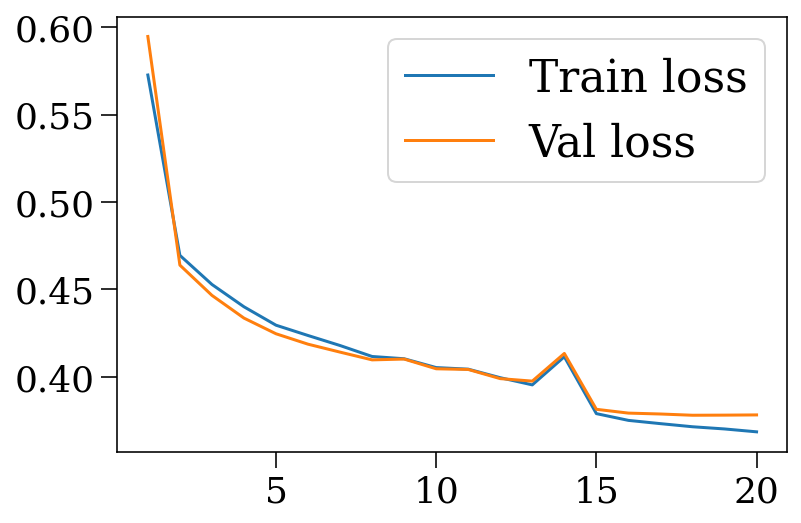

In [5]:
train_loss, val_loss,_ = load_epochlosses(PATH_model, n_data, bs)

plt.plot(range(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(range(1, len(train_loss)+1), val_loss, label='Val loss')
plt.legend()

In [6]:
# linearly spaced array in gamma to test likelihoods on 
n_bin = 151
gammas_test = np.linspace(1.1, 2.9, n_bin)
gammas_test_ctrs = 0.5*(gammas_test[:-1] + gammas_test[1:]) 

gs_train, gs_val, g_mean, mean, std = load_data(PATH, PATH_val, n_data, zero_nsub=False)

In [7]:
model = load_model(PATH_model + 'arrays/', epoch=20, p_dropout=dropout)#, mean=to_tensor(mean), std=to_tensor(std))
model.eval()
if (dropout): enable_dropout(model)


cfg = 50


In [8]:
cal = False

if cal: 
    # load the calibration r values 
    logrs_ref = np.load(PATH_model + 'calib/logrs_ref_n20000_nbin{}_epoch17.npy'.format(n_bin))
    logrs_calib = np.load(PATH_model + 'calib/logrs_calib_n1100_nbin{}_epoch17.npy'.format(n_bin), allow_pickle=True)

In [9]:
gts_sub = gts[3:17] 
print(gts_sub) 
paths_cov = [PATH_test + 'test_g{}/deltapix0.04_numpix100_EPLsh_EPLml_logm7.0to10.0_beta-1.9_nsub0to1800_0.2maxpix_gammaw0.1_zl0.2zs0.6_shear0.1_nms_exptime2200_lenslight_multipole_los_loadpsf/images/SLimage_maskedge_{}.npy'.format(g, '{}') for g in gts_sub] #paths_epl[3:17]

p_ary = np.linspace(0.01, 0.99, 100) 

[1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7]


In [10]:
n_per = 13  # number of images to combine 
n_times = 23 # number of samples per gamma value 

gts_all = np.repeat(gts_sub, n_times) 

if cal: 
    gs_pred_all, err_low_all, err_high_all, gs_pred_all_uc, err_low_all_uc, err_high_all_uc = get_uncertainties_both(model, paths_cov, n_per, n_times, gammas_test_ctrs,
                                                                        g_mean, mean, std, p_ary, calib=True, mask=True, select=False, logrs_calib=np.array(logrs_calib), 
                                                                        logrs_ref=np.array(logrs_ref), n_convolve=5)
else: 
    gs_pred_all, err_low_all, err_high_all, gs_pred_all_uc, err_low_all_uc, err_high_all_uc = get_uncertainties_both(model, paths_cov, n_per, n_times, gammas_test_ctrs,
                                                                                                                     g_mean, mean, std, p_ary, calib=False, mask=True, select=False)

# compute the fraction of images whose ground truths lie within the uncertainty 
em_cov, em_cov_uc = [], []

for err_l, err_h, err_l_uc, err_h_uc in zip(err_low_all.T, err_high_all.T, err_low_all_uc.T, err_high_all_uc.T): 
    condition = (gts_all > err_l)*(gts_all < err_h)
    em_cov.append(np.count_nonzero(condition)/len(err_l))
    
    condition_uc = (gts_all > err_l_uc)*(gts_all < err_h_uc)
    em_cov_uc.append(np.count_nonzero(condition_uc)/len(err_l_uc))

cl2threshold_n13 = interpolate.interp1d(em_cov, p_ary)


100%|██████████| 14/14 [06:27<00:00, 27.70s/it]


In [11]:
n_per = 1  # number of images to combine 
n_times = 200 

gts_all = np.repeat(gts_sub, n_times) 

if cal: 
    gs_pred_all, err_low_all, err_high_all, gs_pred_all_uc, err_low_all_uc, err_high_all_uc = get_uncertainties_both(model, paths_cov, n_per, n_times, gammas_test_ctrs,
                                                                                g_mean, mean, std, p_ary, calib=True, mask=True, select=False, logrs_calib=np.array(logrs_calib), 
                                                                                logrs_ref=np.array(logrs_ref), n_convolve=3)
else:
    gs_pred_all, err_low_all, err_high_all, gs_pred_all_uc, err_low_all_uc, err_high_all_uc = get_uncertainties_both(model, paths_cov, n_per, n_times, gammas_test_ctrs,
                                                                                                                 g_mean, mean, std, p_ary, calib=False, mask=True, select=False)

em_cov, em_cov_uc = [], []

for err_l, err_h, err_l_uc, err_h_uc in zip(err_low_all.T, err_high_all.T, err_low_all_uc.T, err_high_all_uc.T): 
    condition = (gts_all > err_l)*(gts_all < err_h)
    em_cov.append(np.count_nonzero(condition)/len(err_l))
    
    condition_uc = (gts_all > err_l_uc)*(gts_all < err_h_uc)
    em_cov_uc.append(np.count_nonzero(condition_uc)/len(err_l_uc))

cl2threshold_n1 = interpolate.interp1d(em_cov, p_ary)

100%|██████████| 14/14 [03:20<00:00, 14.30s/it]


In [12]:
n_test = 100
i_start = 0

data_val = np.array([np.load(PATH_val + 'images/SLimage_maskedge_{}.npy'.format(i+1)) for i in range(i_start, i_start+n_test)])
mask = (data_val != 0)
data_val = mask*(data_val - mean)/std

data_val = data_val[(2.8 > gs_val[i_start:i_start+n_test])*(gs_val[i_start:i_start+n_test]> 1.2)]

--- 4.983148574829102 seconds ---


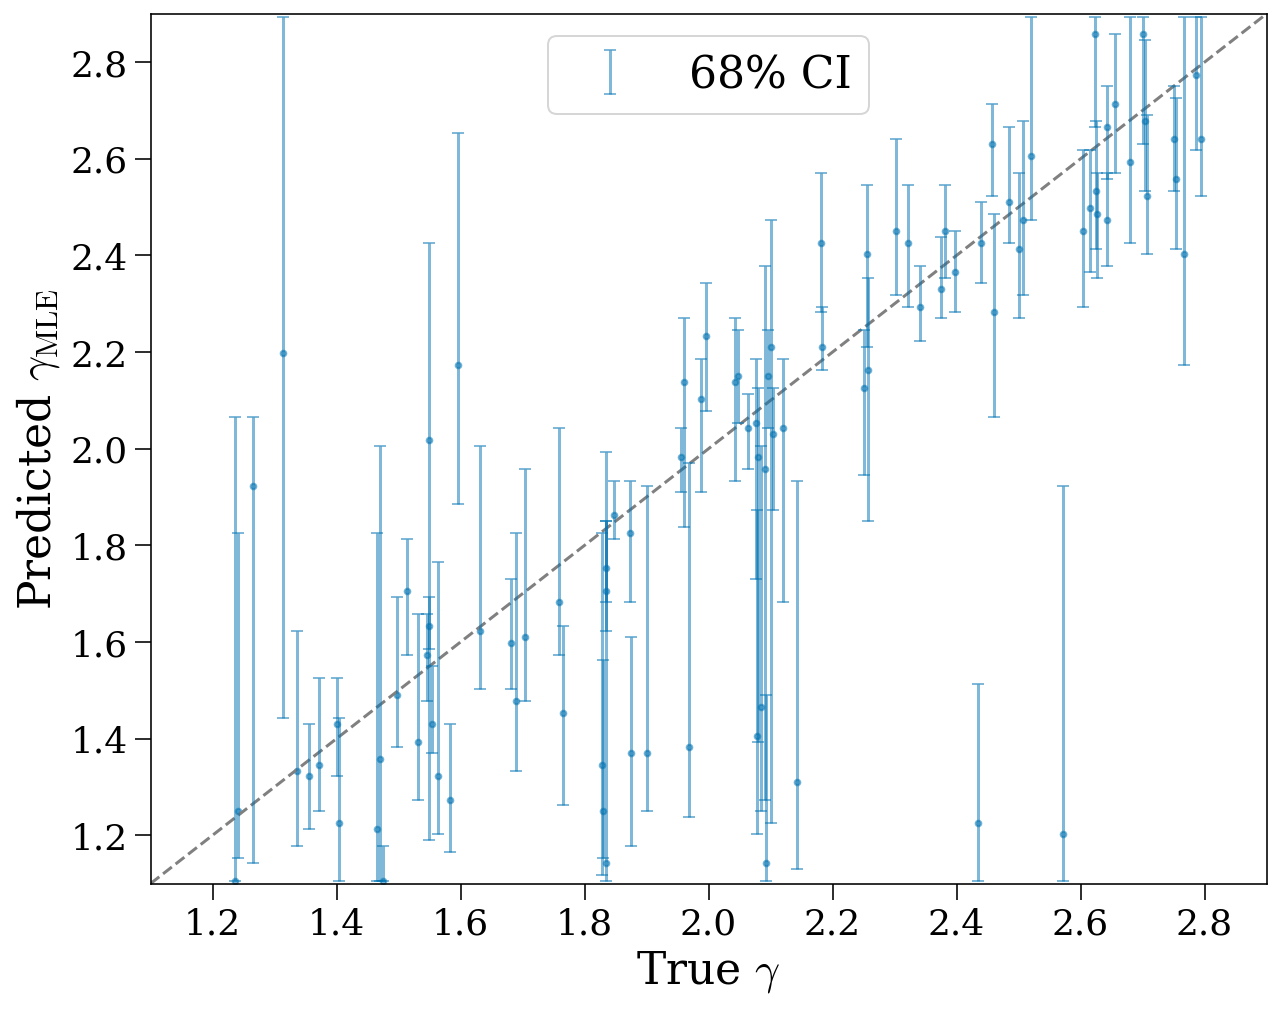

In [13]:
plt.figure(figsize=(10, 8))
plt.plot(gammas_test, gammas_test, color='gray', linestyle='--')
if cal: 
    g_pred, errlow, errhigh = plot_predictions(model, gammas_test_ctrs, gs_val[i_start:i_start+n_test][(2.8 > gs_val[i_start:i_start+n_test])*(gs_val[i_start:i_start+n_test]> 1.2)], 
                                               g_mean, data_val, color=colors[0], label='', 
                                               error='both', select=False, threshold=stats.chi2.isf(1 - cl2threshold_n1(0.68), df=1), calib=False, 
                                               logrs_ref=logrs_ref, logrs_calib=logrs_calib, n_convolve=3)
else: 
    g_pred, errlow, errhigh = plot_predictions(model, gammas_test_ctrs, gs_val[i_start:i_start+n_test][(2.8 > gs_val[i_start:i_start+n_test])*(gs_val[i_start:i_start+n_test]> 1.2)], 
                                               g_mean, data_val, color=colors[0], label='', 
                                               error='both', select=False, threshold=stats.chi2.isf(1 - cl2threshold_n1(0.68), df=1), calib=False)

plt.xlabel(r'True $\gamma$')
plt.ylabel(r'Predicted $\gamma_{\mathrm{MLE}}$')
plt.ylim(1.1, 2.9)
plt.xlim(1.1, 2.9)
plt.legend()

#plt.savefig('../plots/resnet{}_ndata{}_valgamma_scatter_test{}.pdf'.format(cfg, n_data, n_test))

In [14]:
if cal: 
    gs_pred_epl, gs_1sig_low_epl, gs_1sig_high_epl, gs_2sig_low_epl, gs_2sig_high_epl = get_combined_predictions(model, paths_epl[2:-1], 13, gammas_test_ctrs, g_mean, 
                                                                                                             mean=mean, std=std, mask=True, select=False, i_start=0,
                                                                                                             threshold=stats.chi2.isf(1-cl2threshold_n13(0.68), df=1), 
                                                                                                             calib=True, logrs_ref=logrs_ref, 
                                                                                                             logrs_calib=logrs_calib, n_convolve=3)
else: 
    gs_pred_epl, gs_1sig_low_epl, gs_1sig_high_epl, gs_2sig_low_epl, gs_2sig_high_epl = get_combined_predictions(model, paths_epl[2:-1], 13, gammas_test_ctrs, g_mean, 
                                                                                                                 mean=mean, std=std, mask=True, select=False, 
                                                                                                                 threshold=stats.chi2.isf(1-cl2threshold_n13(0.68), df=1), calib=False)


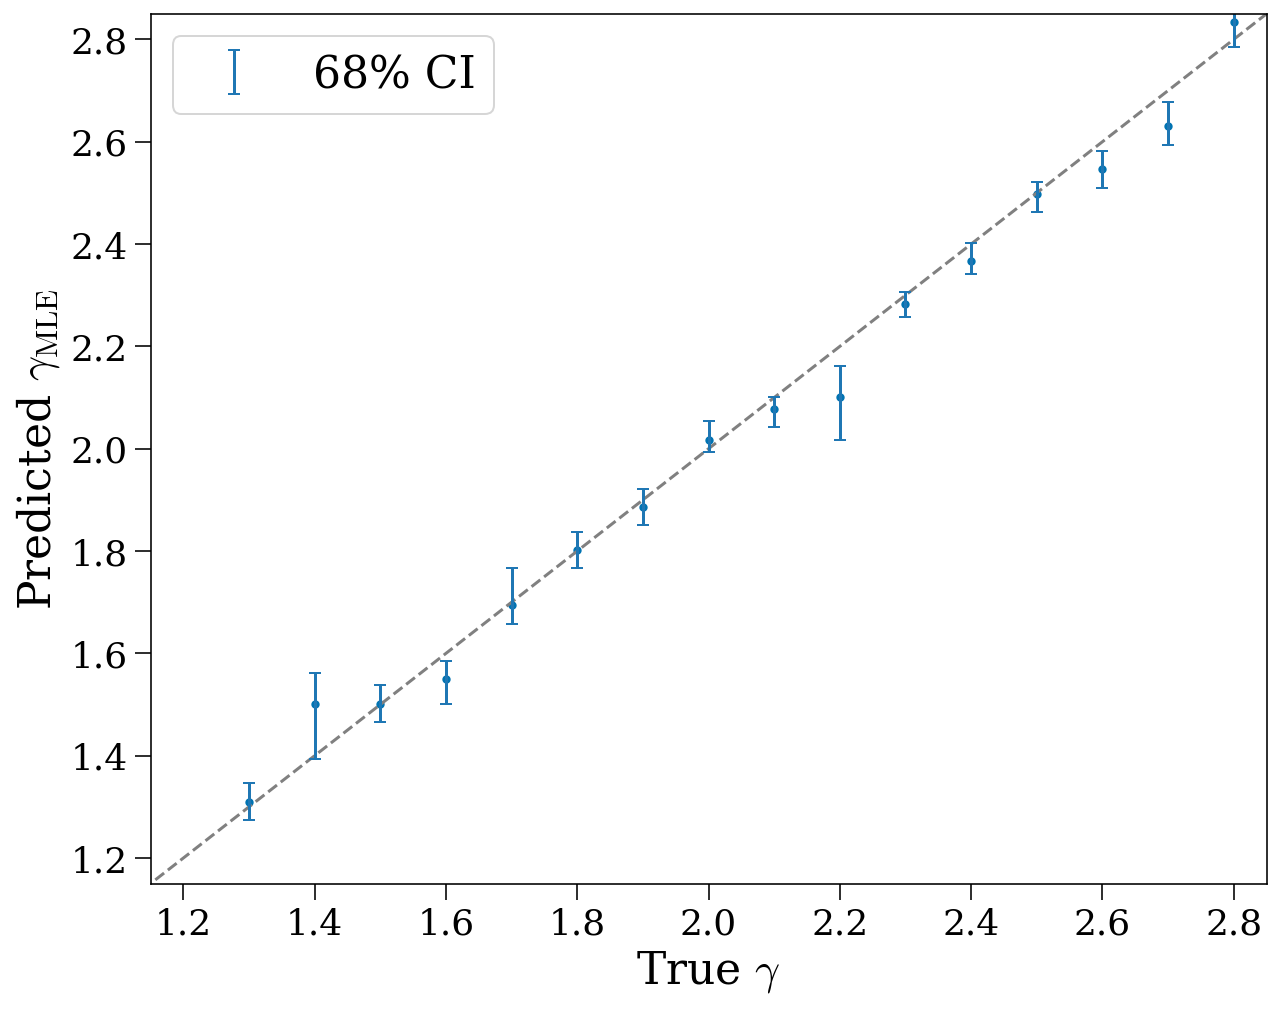

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(gammas_test, gammas_test, color='gray', linestyle='--')
plt.scatter(gts[2:-1], gs_pred_epl, color=colors[0], s=10)
plt.errorbar(gts[2:-1], gs_pred_epl, [gs_pred_epl-gs_1sig_low_epl, gs_1sig_high_epl-gs_pred_epl], fmt='none', capsize=3, label=r'68% CI')
plt.xlabel(r'True $\gamma$')
plt.ylabel(r'Predicted $\gamma_{\mathrm{MLE}}$')
plt.ylim(1.15, 2.85)
plt.xlim(1.15, 2.85)
plt.legend()

#plt.savefig('../plots/resnet{}_ndata{}_nsub0to300_eplcombine{}.pdf'.format(cfg, n_data, n_gt))

In [16]:
if cal: 
    gs_pred_nfw, gs_1sig_low_nfw, gs_1sig_high_nfw, gs_2sig_low_nfw, gs_2sig_high_nfw = get_combined_predictions(model, paths_nfw, 13, gammas_test, g_mean, 
                                                                                                                 mean=mean, std=std, mask=True, select=False, i_start=50, 
                                                                                                                 threshold=stats.chi2.isf(1-cl2threshold_n13(0.68), df=1),
                                                                                                                 calib=True, logrs_ref=logrs_ref, 
                                                                                                                 logrs_calib=logrs_calib, n_convolve=3)

else: 
    gs_pred_nfw, gs_1sig_low_nfw, gs_1sig_high_nfw, gs_2sig_low_nfw, gs_2sig_high_nfw = get_combined_predictions(model, paths_nfw, 13*100, gammas_test, g_mean, 
                                                                                                                 mean=mean, std=std, mask=True, select=False,
                                                                                                                 threshold=stats.chi2.isf(1-cl2threshold_n13(0.68), df=1), 
                                                                                                                 calib=False, i_start=0, n_sets=100)


In [17]:
paths_tnfw = [PATH + 'test_nfw{}/deltapix0.04_numpix100_TNFWsh_EPLml_logm7.0to10.0_beta-1.9_nsub0to12000_0.0maxpix_zl0.2zs0.6_shear0.1_dex0.1_nms_exptime2200_lenslight_multipole_los_loadpsf/images/SLimage_maskedge_{}.npy'.format(c, '{}') for c in nfw_cfactors_str]


if cal: 
    gs_pred_tnfw, gs_1sig_low_tnfw, gs_1sig_high_tnfw, gs_2sig_low_tnfw, gs_2sig_high_tnfw = get_combined_predictions(model, paths_tnfw, 13, gammas_test, g_mean, 
                                                                                                                 mean=mean, std=std, mask=True, select=False, i_start=50, 
                                                                                                                 threshold=stats.chi2.isf(1-cl2threshold_n13(0.68), df=1),
                                                                                                                 calib=True, logrs_ref=logrs_ref, 
                                                                                                                 logrs_calib=logrs_calib, n_convolve=3)

else: 
    gs_pred_tnfw, gs_1sig_low_tnfw, gs_1sig_high_tnfw, gs_2sig_low_tnfw, gs_2sig_high_tnfw = get_combined_predictions(model, paths_tnfw, 13*100, gammas_test, g_mean, 
                                                                                                                 mean=mean, std=std, mask=True, select=False,
                                                                                                                 threshold=stats.chi2.isf(1-cl2threshold_n13(0.68), df=1), 
                                                                                                                 calib=False, i_start=0, n_sets=100)
                                                                                                                 #threshold=stats.chi2.isf(1-cl2threshold_n13(0.68), df=1), 
                                                                                                                 #calib=True, logrs_ref=logrs_ref, 
                                                                                                                 #logrs_calib=logrs_calib, n_convolve=3)


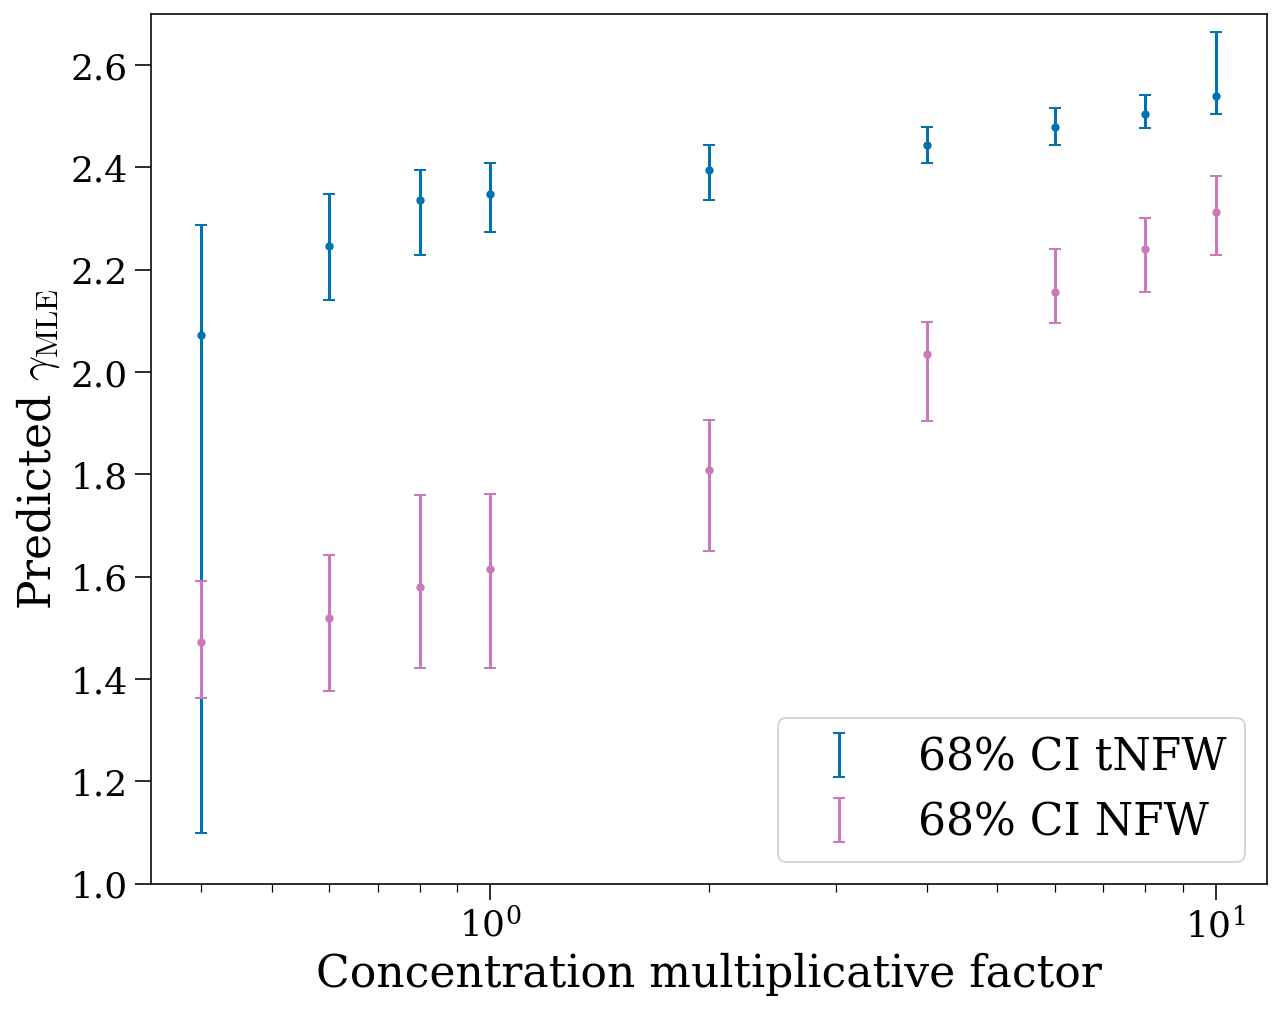

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(nfw_cfactors, gs_pred_tnfw, color=colors[0], s=10)
plt.errorbar(nfw_cfactors, gs_pred_tnfw, [gs_pred_tnfw-gs_1sig_low_tnfw, gs_1sig_high_tnfw-gs_pred_tnfw], fmt='none', capsize=3, label=r'68% CI tNFW', color=colors[0])
plt.scatter(nfw_cfactors, gs_pred_nfw, color=colors[1], s=10)
plt.errorbar(nfw_cfactors, gs_pred_nfw, [gs_pred_nfw-gs_1sig_low_nfw, gs_1sig_high_nfw-gs_pred_nfw], fmt='none', capsize=3, label=r'68% CI NFW', color=colors[1])

#plt.plot(nfw_cfactors, gs_pred_nfw, color=colors[0])
#plt.fill_between(nfw_cfactors, gs_1sig_low_nfw, gs_1sig_high_nfw, label='68% CI', alpha=0.3, color=colors[0])
#plt.plot(nfw_cfactors, gs_pred_tnfw, color=colors[1])
#plt.fill_between(nfw_cfactors, gs_1sig_low_tnfw, gs_1sig_high_tnfw, label='68% CI', alpha=0.3, color=colors[1])

plt.xlabel(r'Concentration multiplicative factor')
plt.ylabel(r'Predicted $\gamma_{\mathrm{MLE}}$')
plt.ylim(1, 2.7)
plt.xscale('log')
plt.legend()

#plt.savefig('../plots/resnet{}_ndata{}_nsub0to12000_tnfwnfwcombine{}.pdf'.format(cfg, n_data, n_nfw))

In [19]:
n_sets = 115

mles_nfw = [] 

for j in trange(n_sets): 
    im_cdm = [np.load(PATH + 'test_nfw1/deltapix0.04_numpix100_NFWsh_EPLml_logm7.0to10.0_beta-1.9_nsub0to12000_0.0maxpix_zl0.2zs0.6_shear0.1_dex0.1_nms_exptime2200_lenslight_multipole_los_loadpsf/images/SLimage_maskedge_{}.npy'.format(i + 1)).astype(np.float32) for i in range(j*n_nfw, (j+1)*n_nfw)]

    mask = (np.array(im_cdm) != 0) 
    im_temp = mask*(im_cdm - mean)/std
    
    logrs_cdm_temp = get_logrs(gammas_test_ctrs - g_mean, im_temp, model)

    if cal: 
        logrs_cdm_temp = calibrate(logrs_cdm_temp, logrs_calib, logrs_ref)
    else: 
        g_cdm_temp = gammas_test_ctrs

    logr_cdm_temp = np.sum(logrs_cdm_temp, axis=1)
    
    if cal: 
        g_cdm_temp, logr_cdm_temp = convolve_logr(gammas_test_ctrs, logr_cdm_temp, 5)

    mles_nfw.append(g_cdm_temp[np.argmax(logr_cdm_temp)])


100%|██████████| 115/115 [01:23<00:00,  1.38it/s]


In [20]:
n_sets_tnfw = 150

mles_tnfw = []

for j in trange(n_sets_tnfw): 
    im_tnfw = [np.load(PATH + 'test_nfw1/deltapix0.04_numpix100_TNFWsh_EPLml_logm7.0to10.0_beta-1.9_nsub0to12000_0.0maxpix_zl0.2zs0.6_shear0.1_dex0.1_nms_exptime2200_lenslight_multipole_los_loadpsf/images/SLimage_maskedge_{}.npy'.format(i + 1)).astype(np.float32) for i in range(j*n_nfw, (j+1)*n_nfw)]

    mask = (np.array(im_tnfw) != 0) 
    im_temp_tnfw = mask*(im_tnfw - mean)/std
    
    logrs_tnfw_temp = get_logrs(gammas_test_ctrs - g_mean, im_temp_tnfw, model)
    
    if cal: 
        logrs_tnfw_temp = calibrate(logrs_tnfw_temp, logrs_calib, logrs_ref)
    else: 
        g_tnfw_temp = gammas_test_ctrs
        
    logr_tnfw_temp = np.sum(logrs_tnfw_temp, axis=1)
    
    if cal: g_tnfw_temp, logr_tnfw_temp = convolve_logr(gammas_test_ctrs, logr_tnfw_temp, 5)
    
    mles_tnfw.append(g_tnfw_temp[np.argmax(logr_tnfw_temp)])

100%|██████████| 150/150 [02:00<00:00,  1.24it/s]


In [21]:
nfw16, nfw50, nfw84 = np.percentile(mles_nfw, [16, 50, 84])
tnfw16, tnfw50, tnfw84 = np.percentile(mles_tnfw, [16, 50, 84])

In [22]:
data_names = ['SDSSJ1023+4230', 'GAL-0364-52000-084', 'SDSSJ0946+1006', 
             '0722-52224-442', '0902-52409-068', 'SDSSJ0822+2652', '0677-52606-520', 
             'SDSSJ0936+0913', 'SDSSJ1103+5322', '0605-52353-503', 'SDSSJ0728+3835',
             '0969-52442-134', 'SDSSJ1142+1001']

data_names_sdss = ['SDSSJ1023+4230', r'SDSSJ1627$-$0053', 'SDSSJ0946+1006', 
             r'SDSSJ2238$-$0754', 'SDSSJ0956+5100', 'SDSSJ0822+2652', 'SDSSJ2300+0022', 
             'SDSSJ0936+0913', 'SDSSJ1103+5322', 'SDSSJ1402+6321', 'SDSSJ0728+3835',
             'SDSSJ1205+4910', 'SDSSJ1142+1001']

# masking parameters 
masks_r = [48, 45, 49, 46, 49, 50, 44, 45, 40, 44, 45, 42, 48]
xs_c = [48, 49, 49, 50, 50, 50, 50, 50, 50, 47, 50, 49, 49]
ys_c = [47, 48, 48, 48, 50, 50, 50, 50, 50, 48, 48, 52, 48]

# test for robustness against the masking parameters 
#add_test = np.random.normal(0, 0.5, 13)
#ys_c += add_test 

x_grid, y_grid = np.meshgrid(np.arange(100), np.arange(100))

In [23]:
logr_hst = np.ones(len(gammas_test_ctrs))

masks = [] 
logrs_hst = [] 
logrs_precalib = [] 

for i, d_name in enumerate(data_names): 
    im_temp = np.load('../data/{}_npix100.npy'.format(d_name)).astype(np.float32)
    im_temp = (im_temp - mean)/std 
    mask = (x_grid.reshape(np.shape(im_temp)) - xs_c[i])**2 + (y_grid.reshape(np.shape(im_temp)) - ys_c[i])**2 < masks_r[i]**2
    masks.append(mask) 
    
    logr_temp = get_logrs(gammas_test_ctrs - g_mean, np.array([im_temp*mask]), model) 
    logrs_precalib.append(logr_temp) 
    if cal: logr_temp = calibrate(logr_temp, logrs_calib, logrs_ref)
    
    logr_hst += logr_temp.T[0]
    
    logrs_hst.append(logr_temp)


logrs_hst = np.array(logrs_hst)
logrs_precalib = np.array(logrs_precalib) 

if cal: g_hst, logr_hst_smooth = convolve_logr(gammas_test_ctrs, logr_hst.flatten(), 5)
else: 
    g_hst = gammas_test_ctrs
    logr_hst_smooth = logr_hst
    logr_hst_smooth -= np.max(logr_hst_smooth) 

#i_low_hst, i_high_hst = find_closestvalue_indices(-2*logr_hst_smooth, chi2.isf(1-cl2threshold_n13(0.68), df=1), np.argmax(logr_hst))


In [24]:
i_low_hst, i_high_hst = find_closestvalue_indices(-2*logr_hst_smooth, chi2.isf(1-cl2threshold_n13(0.68), df=1), np.argmax(logr_hst))


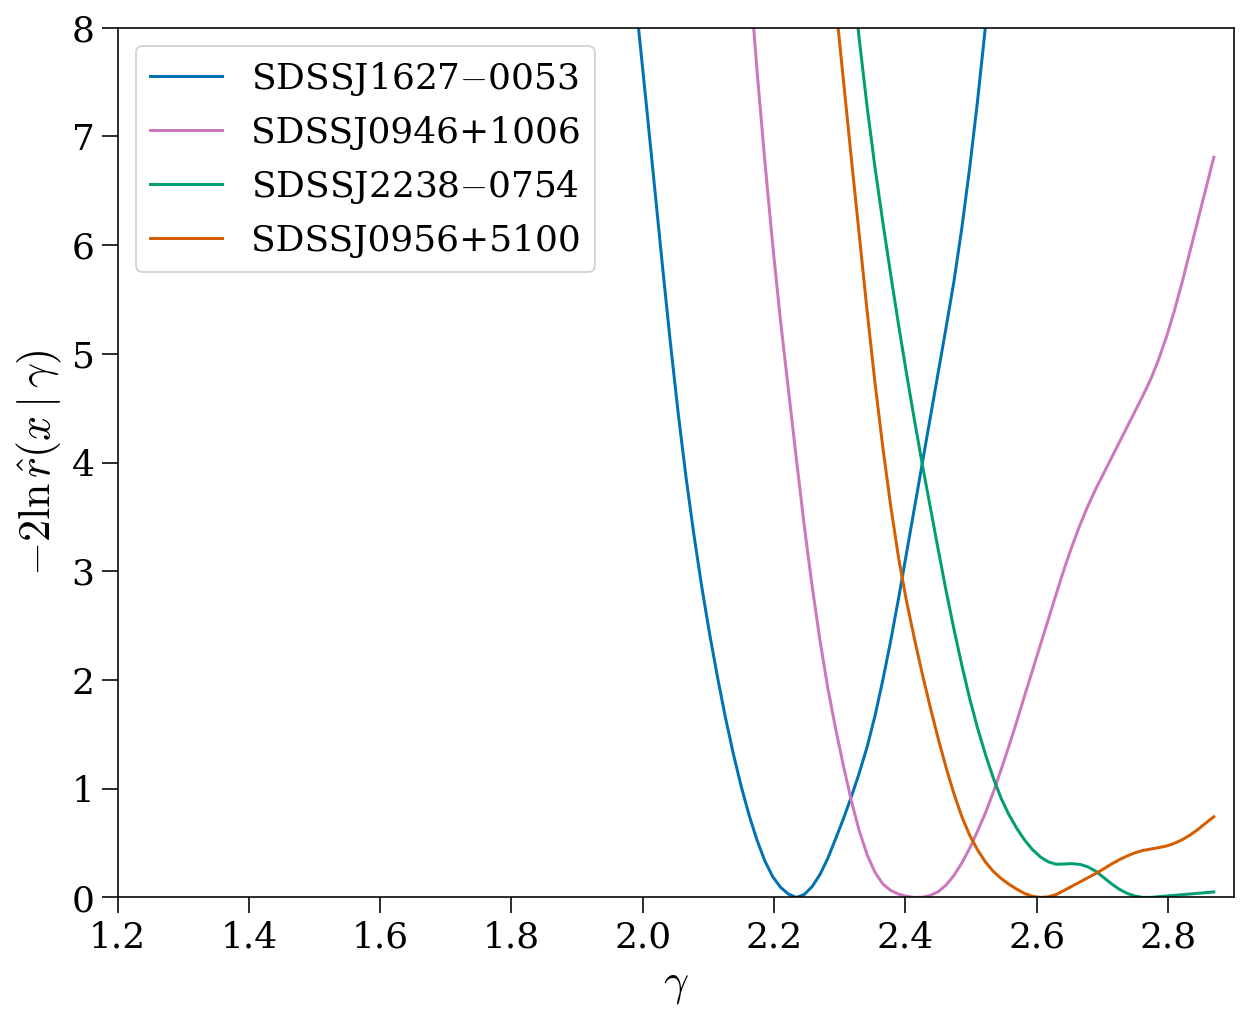

In [25]:
plt.figure(figsize=(10, 8))
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$- 2 \ln \hat{r}(x \mid \gamma)$')


for i, (d_name, lr, lr_pc) in enumerate(zip(data_names_sdss[1:5], logrs_hst[1:5], logrs_precalib[1:5])): 
    #plt.plot(gammas_test_ctrs, -2*(lr-np.amax(lr)), color=colors[i], linestyle=':') 
    g_ctrs_temp, lr = convolve_logr(gammas_test_ctrs, lr, 5)
    plt.plot(g_ctrs_temp, -2*lr, label=d_name, color=colors[i])
    #plt.plot(gammas_test_ctrs, -2*lr_pc, label=d_name, color=colors[i], linestyle='--')
    
#plt.axhline(chi2.isf(1-cl2threshold_n1(0.68), df=1), color='dimgrey', alpha=0.6, lw=1, linestyle='--')
#t = plt.text(2, chi2.isf(1-cl2threshold_n1(0.68), df=1), r"68% CL",  color='dimgrey', alpha=0.6, fontsize=16, verticalalignment='center')
#t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

plt.xlim(1.2, 2.9)
plt.ylim(0, 8)
plt.legend(fontsize=18)
#plt.show()

#plt.savefig('../plots/resnet{}_ndata{}_hstsamples_conv5.pdf'.format(cfg, n_data))

'\nprint(g_cdm[np.argmax(logr_cdm_smooth)])\nprint(g_cdm[np.argmax(logr_cdm_smooth)] - g_cdm[i_low_cdm]) \nprint(g_cdm[i_high_cdm] - g_cdm[np.argmax(logr_cdm_smooth)])\n\nprint(g_hst[np.argmax(logr_hst_smooth)])\nprint(g_hst[np.argmax(logr_hst_smooth)] - g_hst[i_low_hst])\nprint(g_hst[i_high_hst] - g_hst[np.argmax(logr_hst_smooth)])\n'

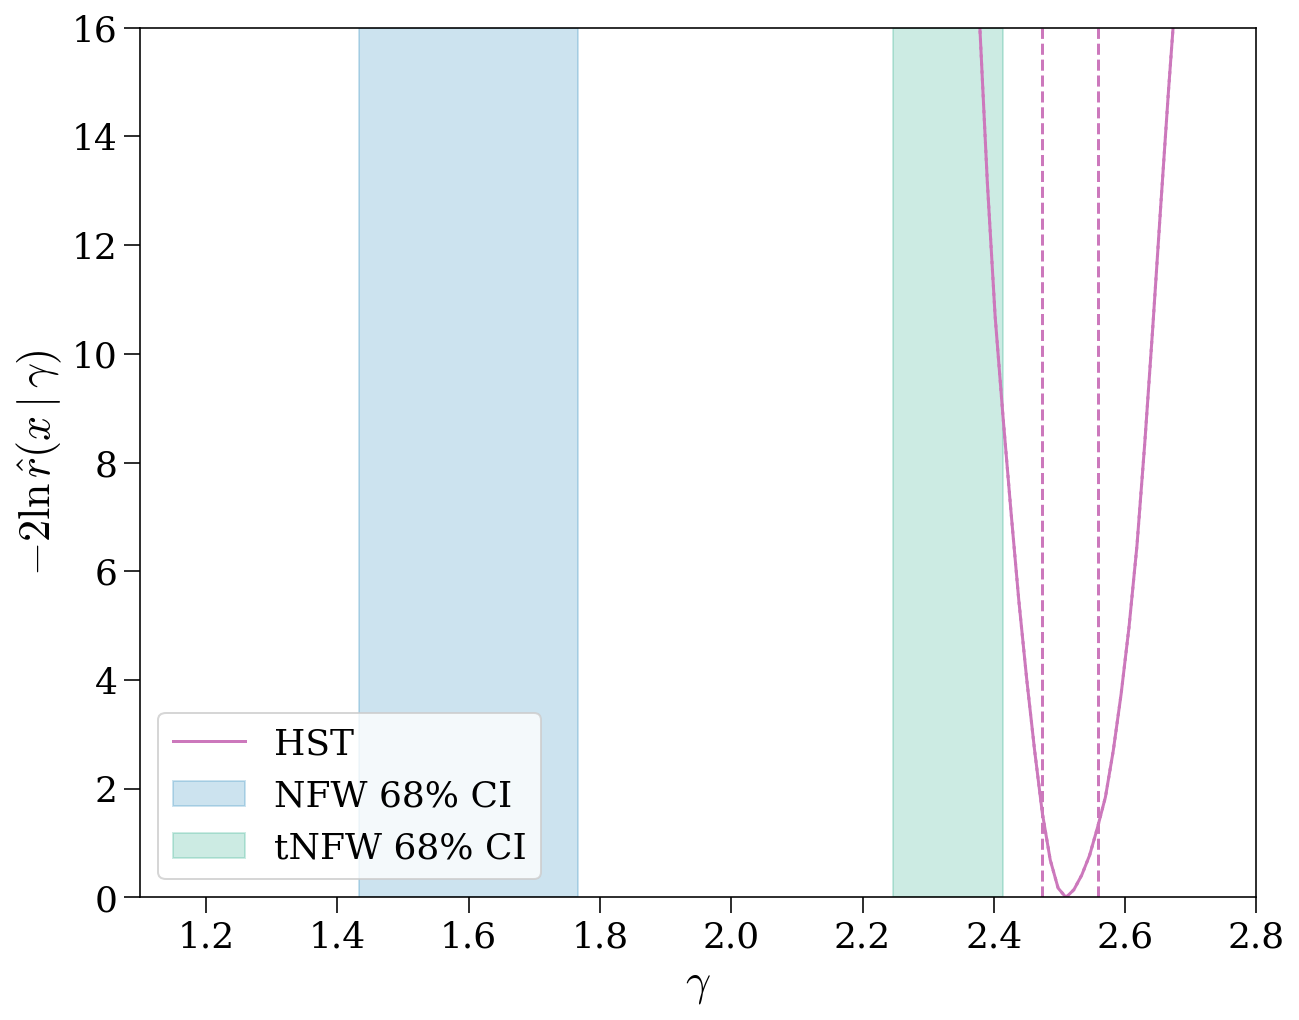

In [28]:
plt.figure(figsize=(10, 8))
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$-2 \ln \hat{r}(x\mid\gamma)$')

#plt.plot(g_cdm, -2*logr_cdm_smooth, color=colors[0], label='NFW')
plt.plot(g_hst, -2*logr_hst_smooth, color=colors[1], label='HST')

#plt.plot(gammas_test_ctrs, -2*(logr_cdm-np.amax(logr_cdm)), color=colors[0], linestyle=':', label='Pre-smoothing')
plt.plot(gammas_test_ctrs, -2*(logr_hst-np.amax(logr_hst)), color=colors[1], linestyle=':')

#plt.axvline(g_cdm[i_low_cdm], color=colors[0], linestyle='--', label='68% CI')
#plt.axvline(g_cdm[i_high_cdm], color=colors[0], linestyle='--')
plt.axvspan(nfw16, nfw84, color=colors[0], linestyle='solid', label='NFW 68% CI', alpha=0.2)
plt.axvspan(tnfw16, tnfw84, color=colors[2], linestyle='solid', label='tNFW 68% CI', alpha=0.2)
#plt.axvline(cdm50, color=colors[0])
plt.axvline(g_hst[i_low_hst], color=colors[1], linestyle='--')
plt.axvline(g_hst[i_high_hst], color=colors[1], linestyle='--')

#plt.axhline(chi2.isf(1 - cl2threshold_n13(0.68), df=1), color='gray', linestyle='--')

plt.xlim(1.1, 2.8)
plt.ylim(0, 16) 
plt.legend(fontsize=18, loc='lower left')

'''
print(g_cdm[np.argmax(logr_cdm_smooth)])
print(g_cdm[np.argmax(logr_cdm_smooth)] - g_cdm[i_low_cdm]) 
print(g_cdm[i_high_cdm] - g_cdm[np.argmax(logr_cdm_smooth)])

print(g_hst[np.argmax(logr_hst_smooth)])
print(g_hst[np.argmax(logr_hst_smooth)] - g_hst[i_low_hst])
print(g_hst[i_high_hst] - g_hst[np.argmax(logr_hst_smooth)])
'''

#print((g_hst[np.argmax(logr_hst)] - g_cdm[np.argmax(logr_cdm)])/(g_cdm[i_high_cdm] - g_cdm[np.argmax(logr_cdm)]))
#print((g_hst[np.argmax(logr_hst)] - g_cdm[np.argmax(logr_cdm)])/(g_hst[np.argmax(logr_hst)] - g_hst[i_low_hst]))

#print('resnet{}_ndata{}_hstvscdm_hstmle{:.2f}.pdf'.format(cfg, n_data, g_hst[np.argmax(logr_hst)]))
#plt.savefig('../plots/resnet{}_ndata{}_hstvscdm_hstmle{:.2f}.pdf'.format(cfg, n_data, g_hst[np.argmax(logr_hst)]))


13


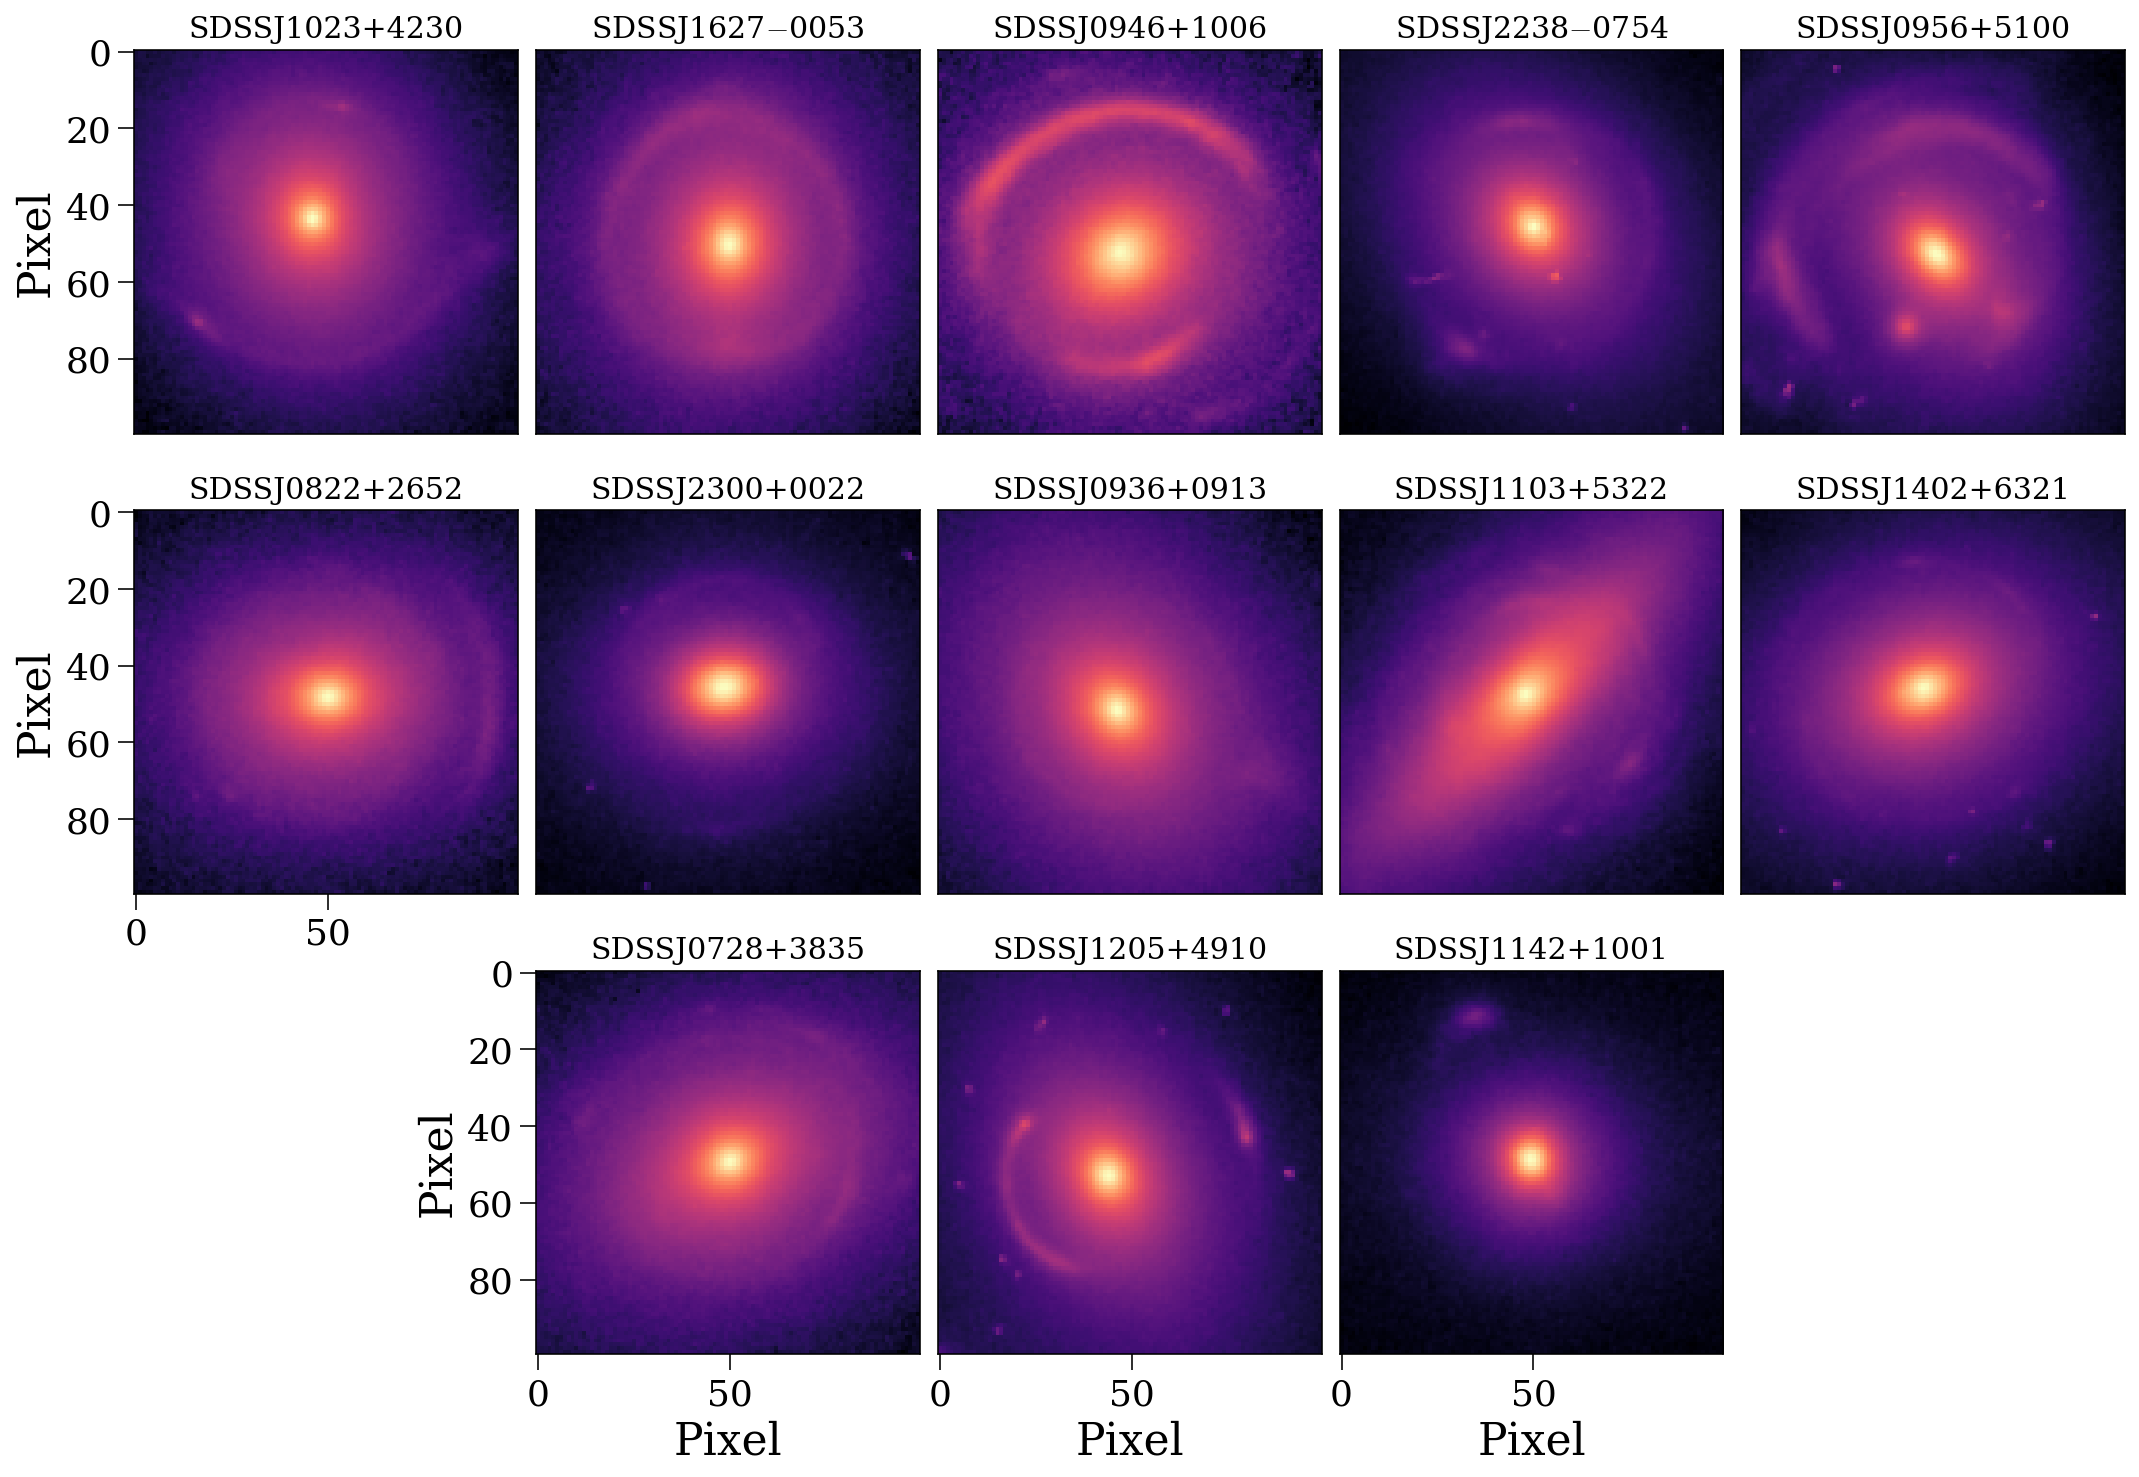

In [27]:
n_hstdata = len(data_names) 
print(n_hstdata)
n_perrow = 5

fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(n_hstdata//n_perrow + 1, 2*n_perrow)
gs.update(wspace=0, hspace=0.2)

for i, d_name in enumerate(data_names): 
    im_temp = np.load('../data/{}_npix100.npy'.format(d_name)).astype(np.float32)
    
    if i < 2*n_perrow: 
        ax = plt.subplot(gs[i//n_perrow, 2 * (i % n_perrow):2 * ((i % n_perrow) + 1)])
    else: 
        ax = plt.subplot(gs[i//n_perrow, 2 * i - 2*(2*n_perrow - 1):2 * (i + 1) - 2*(2*n_perrow - 1)])
        
    ax.imshow(np.log(im_temp), cmap='magma') #*masks[i])
    ax.set_title(data_names_sdss[i], fontsize=15)
    
    # Hide X and Y axes label marks
    if (i % n_perrow != 0): 
        ax.yaxis.set_tick_params(labelleft=False)
        
        # Hide X and Y axes tick marks
        ax.set_yticks([])
        
        # not last row 
        if (i//n_perrow < n_hstdata//n_perrow): 
            ax.xaxis.set_tick_params(labelbottom=False)
            ax.set_xticks([])
        else: 
            ax.set_xlabel('Pixel')
    else: 
        ax.set_ylabel('Pixel')
        if (i//n_perrow == n_hstdata//n_perrow): ax.set_xlabel('Pixel')
        
    if (i == 0): 
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.set_xticks([])

#plt.savefig('../plots/hst_images.pdf')